# Age Regression Notebook

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
feature_path = "../data/features.csv"
voices_path = "../data/voices.csv"

In [3]:
features = pd.read_csv(feature_path, index_col="clip_id")
voices = pd.read_csv(voices_path, index_col="clip_id")

In [4]:
# turn 90 and 80 to >= 80
data = pd.merge(features, voices["voice_age_group"], left_index=True, right_index=True)
data.loc[data.voice_age_group == 90, "voice_age_group"] = 80
data.voice_age_group = (data.voice_age_group-20) / 60
data.voice_age_group.value_counts()

voice_age_group
0.000000    233029
0.166667    121920
0.333333     70728
0.500000     56769
0.666667     53183
0.833333      7509
1.000000       668
Name: count, dtype: int64

In [ ]:
data = data.groupby('voice_age_group', group_keys=False).apply(
    lambda x: x.sample(n=2000, replace=True, random_state=42)
).sample(frac=1, random_state=42)
data.voice_age_group.value_counts()

/tmp/ipykernel_33206/2351861745.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('voice_age_group', group_keys=False).apply(


voice_age_group
1.000000    1000
0.333333    1000
0.000000    1000
0.666667    1000
0.500000    1000
0.833333    1000
0.166667    1000
Name: count, dtype: int64

In [6]:
data.head()

,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp,voice_age_group
clip_id,,,,,,,,,,,,,,,,,,,,,
582ae600-2b15-4283-8350-9ac24592400c,33.968296,0.190947,30.591419,32.390579,34.637905,4.046486,321.752380,228.634598,65.155945,78.549965,...,0.004079,0.545338,3.174603,1.960784,0.280000,0.363843,0.228000,0.252895,-14.948453,1.000000
e6805526-7af9-435c-a172-e166e4fe2277,23.189672,0.466016,17.741768,19.627081,24.403843,6.662075,198.168152,134.744980,92.718468,72.359268,...,-0.000793,1.152616,3.020134,2.707276,0.191250,0.197163,0.148235,0.128211,-14.484736,0.333333
48c69ae9-69ea-4395-9fa5-0b03fbb0276c,31.133549,0.123046,29.521891,31.987000,33.631134,4.109243,221.240967,205.312576,203.375748,127.908646,...,0.003517,0.030584,0.476191,0.975610,0.225000,0.115000,0.770000,0.210000,-21.350786,0.333333
bed587c7-fb9c-4ea8-b739-3f9ca096e54f,39.724113,0.245326,33.666218,36.944778,49.172596,15.506378,279.261536,380.723816,175.836609,24.099794,...,0.019945,0.172537,2.261307,2.544529,0.146000,0.139370,0.225000,0.419386,-21.050049,0.000000
e7c201fe-dd99-48db-a460-d3c598f710a2,28.573614,0.386994,19.368578,26.829224,31.936081,12.567503,198.091599,96.100502,233.604111,176.441513,...,0.008108,0.126041,1.466993,1.732673,0.268571,0.262647,0.251250,0.285633,-25.095919,0.666667


In [7]:
X = data.drop(columns=["voice_age_group"])
y = data["voice_age_group"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

In [10]:
def evaluate_model_classification(model, X_train, X_test):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
    print("Test Accuracy:", accuracy_score(y_test, y_pred_test))

    age_bins = [20, 30, 40, 50, 60, 70, 80]

    sns.heatmap(
    confusion_matrix(y_test, y_pred_test),
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=age_bins,
        yticklabels=age_bins
    )
    plt.xlabel("Predicted Age Group")
    plt.ylabel("True Age Group")
    plt.title("Confusion Matrix")

In [ ]:

def evaluate_model_regression(model, X_train, X_test, y_train, y_test):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    y_pred_test_rounded = np.round(model.predict(X_test))

    # Regression metrics
    print("Train MAE:", mean_absolute_error(y_train, y_pred_train))
    print("Test MAE:", mean_absolute_error(y_test, y_pred_test))
    print("Rounded Test MAE:", mean_absolute_error(y_test, y_pred_test_rounded))
    print("\nTrain MSE:", mean_squared_error(y_train, y_pred_train))
    print("Test MSE:", mean_squared_error(y_test, y_pred_test))
    print("\nTrain R²:", r2_score(y_train, y_pred_train))
    print("Test R²:", r2_score(y_test, y_pred_test))

    # Scatter plot of true vs predicted values
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=y_pred_test, alpha=0.6)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # Diagonal line
    plt.xlabel("True Age")
    plt.ylabel("Predicted Age")
    plt.title("True vs Predicted Age (Test Set)")
    plt.show()

    # Residual plot (helps check for bias)
    """
    residuals = y_test - y_pred_test
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_pred_test, y=residuals, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel("Predicted Age")
    plt.ylabel("Residuals (True - Predicted)")
    plt.title("Residual Plot")
    plt.show()
    """

# Linear Regression

In [12]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train_s, y_train)

LinearRegression()

Train MAE: 0.23878573634922604
Test MAE: 0.24731674508048399
Rounded Test MAE: 0.3575

Train MSE: 0.08162055977933234
Test MSE: 0.08838432050336056

Train R²: 0.2634085900988403
Test R²: 0.21310452554438242


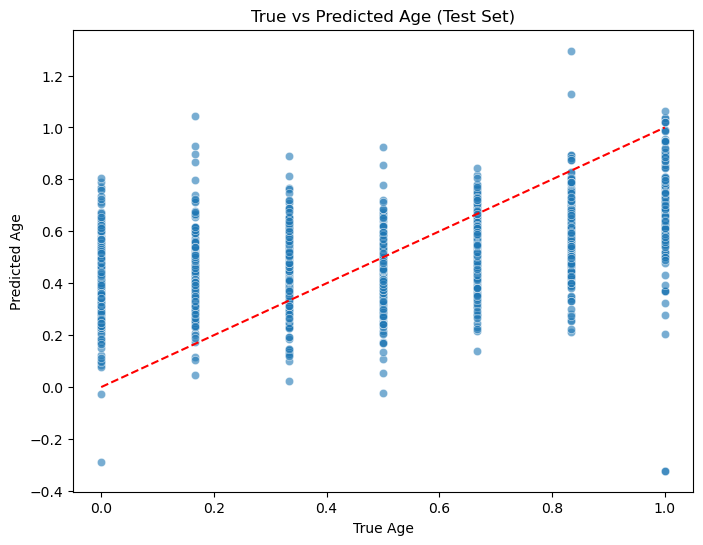

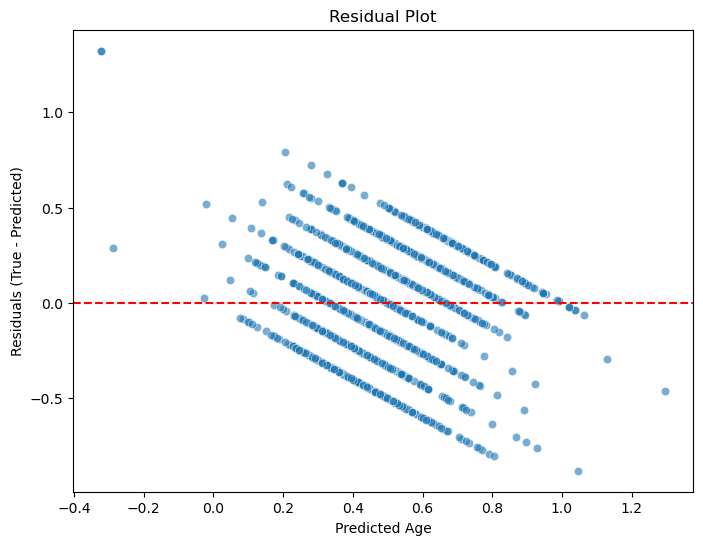

In [13]:
evaluate_model_regression(model, X_train_s, X_test_s, y_train, y_test)

# Random Forest Regressor

In [14]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

Train MAE: 0.06791071428571438
Test MAE: 0.18802738095238097
Rounded Test MAE: 0.30511904761904757

Train MSE: 0.007493287698412706
Test MSE: 0.05665216468253968

Train R²: 0.9323762129849242
Test R²: 0.4956194520371988


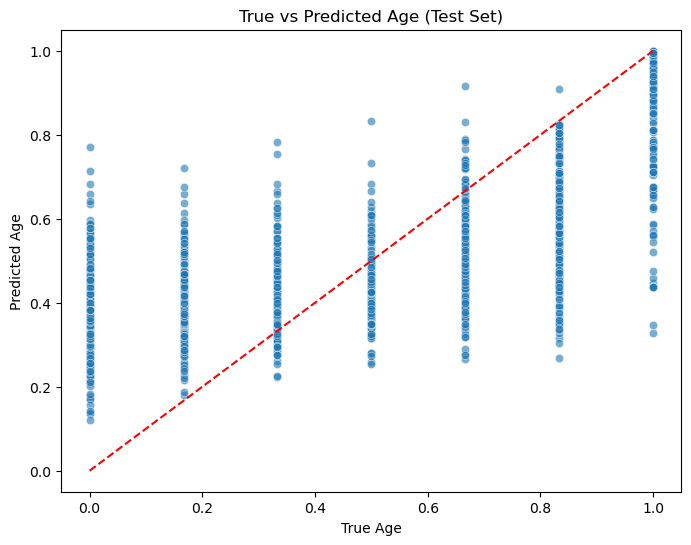

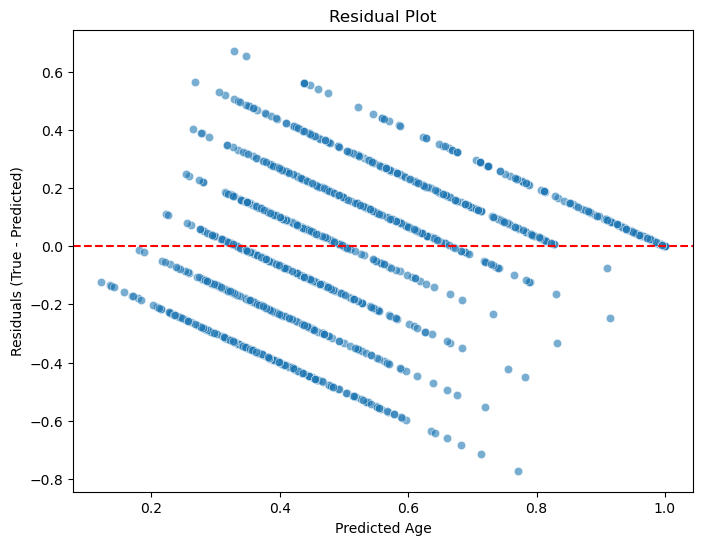

In [15]:
evaluate_model_regression(model, X_train, X_test, y_train, y_test)

# XGB Boost

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END ......................max_depth=3, n_estimators=300; total time=   4.2s
[CV] END ......................max_depth=3, n_estimators=300; total time=   4.3s
[CV] END ......................max_depth=3, n_estimators=300; total time=   4.4s
[CV] END ......................max_depth=3, n_estimators=500; total time=   5.7s
[CV] END ......................max_depth=3, n_estimators=500; total time=   5.8s
[CV] END ......................max_depth=3, n_estimators=500; total time=   6.0s
[CV] END ......................max_depth=5, n_estimators=300; total time=   9.7s
[CV] END .....................max_depth=3, n_estimators=1000; total time=   9.9s
[CV] END .....................max_depth=3, n_estimators=1000; total time=  10.0s
[CV] END .....................max_depth=3, n_estimators=1000; total time=  10.4s
[CV] END ......................max_depth=5, n_estimators=300; total time=  10.4s
[CV] END ......................max_depth=5, n_est

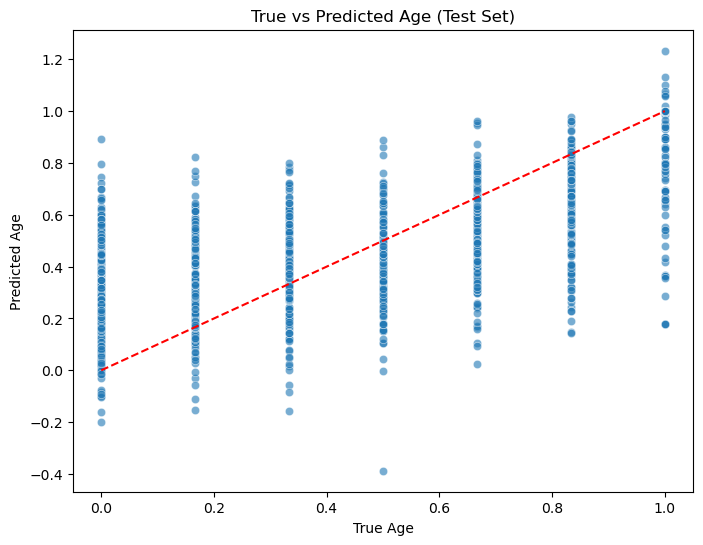

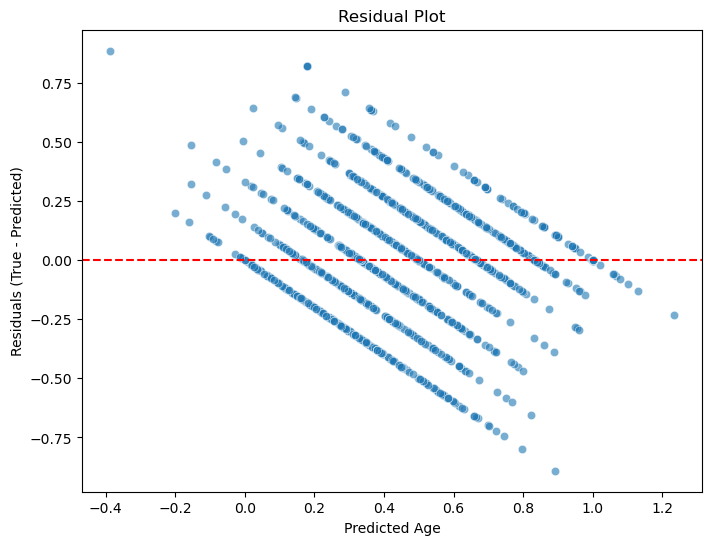

In [16]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [300, 500, 1000],       # Number of trees
    'max_depth': [3, 5, 7],                # Tree depth (lower = less overfitting)
}

# Initialize the model
model = XGBRegressor(random_state=42, objective='reg:squarederror')

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',  # Focus on MAE (aligns with your metric)
    cv=3,                               # 5-fold cross-validation
    n_jobs=-1,                          # Use all CPU cores
    verbose=2
)

# Run the grid search
grid_search.fit(X_train, y_train)

# Best parameters and results
print("Best Parameters:", grid_search.best_params_)
print("Best MAE:", -grid_search.best_score_)
evaluate_model_regression(grid_search.best_estimator_, X_train, X_test, y_train, y_test)